In [1]:
import spatialdata
import dask_image.imread
import dask.array as da
import napari_spatialdata

import sys, os
sys.path.append(os.path.abspath("../src/opendvp/"))
import anndata_utils

for package in [spatialdata, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


spatialdata: 0.3.0
napari_spatialdata: 0.5.5


In [ ]:
!mamba list

# packages in environment at /opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata:
#
# Name                    Version                   Build  Channel
aiobotocore               2.5.4                    pypi_0    pypi
aiohappyeyeballs          2.4.6              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.13         py312h998013c_0    conda-forge
aioitertools              0.12.0                   pypi_0    pypi
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
alabaster                 1.0.0              pyhd8ed1ab_1    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0              pyhd8ed1ab_1    conda-forge
aom                       3.9.1                h7bae524_0    conda-forge
app-model                 0.3.0              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4              pyhd8ed1ab_1    conda-forge
appnope                   0.1.4              pyhd8ed1ab_

In [9]:
#paths
path_to_image = "../data/TNBC_subset/image/TD_15_TNBC_subset.ome.tif"
path_to_mask = "../data/TNBC_subset/mask/TD_15_TNBC_subset.tif"
path_to_quant = "../data/TNBC_subset/quant/TD_15_TNBC_subset.csv" 

# Test 1: sdata from TNBC subset, no chunking

In [10]:
#create sdata
sdata = spatialdata.SpatialData()

In [11]:
#parse mIF image
image = dask_image.imread.imread(path_to_image)
sdata['image'] = spatialdata.models.Image2DModel.parse(image)

#parse mask
mask = dask_image.imread.imread(path_to_mask)
mask = da.squeeze(mask) #remove singleton dimension
sdata['mask'] = spatialdata.models.Labels2DModel.parse(mask)

#parse quantification table
adata = anndata_utils.read_quant(path_to_quant) #create adata from csv
sdata["imaging"] = spatialdata.models.TableModel.parse(adata)

sdata

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


2025-02-25 13:38:14.712 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-02-25 13:38:14.767 | INFO     | anndata_utils:read_quant:36 -  16808 cells and 15 variables
2025-02-25 13:38:14.768 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 0s  ----


SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [20]:
sdata['image']

<xarray.DataArray 'image' (c: 15, y: 5000, x: 5000)> Size: 375MB
dask.array<_map_read_frame, shape=(15, 5000, 5000), dtype=uint8, chunksize=(1, 5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * y        (y) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
  * x        (x) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
Attributes:
    transform:  {'global': Identity }

In [21]:
sdata['mask']

<xarray.DataArray 'image' (y: 5000, x: 5000)> Size: 50MB
dask.array<getitem, shape=(5000, 5000), dtype=uint16, chunksize=(5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
  * x        (x) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
Attributes:
    transform:  {'global': Identity }

In [12]:
sdata.write('../data/sdata/20250225_test1_tnbc_subset_nochunks.zarr')

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../data/sdata/20250225_test1_tnbc_subset_nochunks.zarr                                                    


# Test 2: Create and export with chunking

In [14]:
sdata2 = spatialdata.SpatialData()

In [16]:
#parse image
image = dask_image.imread.imread(path_to_image)
image = image.rechunk(chunks=(1,1000, 1000))
parsed_image = spatialdata.models.Image2DModel.parse(image)
sdata2['image'] = parsed_image

#parse mask
mask = dask_image.imread.imread(path_to_mask)
mask = da.squeeze(mask)
assert mask.ndim == 2
mask = mask.rechunk(chunks=(1000, 1000))
sdata2['mask'] = spatialdata.models.Labels2DModel.parse(mask)

#parse quantification table
adata = anndata_utils.read_quant(path_to_quant) #create adata from csv
sdata2["imaging"] = spatialdata.models.TableModel.parse(adata)

sdata2

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:71: UserWarning: Key `image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-02-25 13:42:46.786 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-02-25 13:42:46.864 | INFO     | anndata_utils:read_quant:36 -  16808 cells and 15 variables
2025-02-25 13:42:46.865 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 0s  ----


SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [18]:
#check chunking
sdata2['image']

<xarray.DataArray 'image' (c: 15, y: 5000, x: 5000)> Size: 375MB
dask.array<rechunk-merge, shape=(15, 5000, 5000), dtype=uint8, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * y        (y) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
  * x        (x) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
Attributes:
    transform:  {'global': Identity }

In [19]:
sdata2['mask']

<xarray.DataArray 'image' (y: 5000, x: 5000)> Size: 50MB
dask.array<rechunk-merge, shape=(5000, 5000), dtype=uint16, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
  * x        (x) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
Attributes:
    transform:  {'global': Identity }

In [22]:
sdata2.write("../data/sdata/20250225_test2_tnbc_subset_chunks.zarr")

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../data/sdata/20250225_test2_tnbc_subset_chunks.zarr                                                      


# Reload zarrs

In [23]:
del sdata
del sdata2

In [25]:
sdata = spatialdata.read_zarr("../data/sdata/20250225_test1_tnbc_subset_nochunks.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [26]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/20250225_test1_tnbc_subset_nochunks.zarr
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [ ]:
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()
#works well

In [28]:
sdata2 = spatialdata.read_zarr("../data/sdata/20250225_test2_tnbc_subset_chunks.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [29]:
sdata2

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/20250225_test2_tnbc_subset_chunks.zarr
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [ ]:
interactive = napari_spatialdata.Interactive(sdata2)
interactive.run()
#works well

# Test 3: Create sdata with image and mask as multimodal

In [70]:
sdata3 = spatialdata.SpatialData()
#parse mIF image
sdata3['image'] = spatialdata.models.Image2DModel.parse(
    data=dask_image.imread.imread(path_to_image),
    dims=['c', 'y', 'x'],
    transformations=None,
    scale_factors=[2,2],
    )

#parse mask
sdata3['mask'] = spatialdata.models.Labels2DModel.parse(
    data=da.squeeze(dask_image.imread.imread(path_to_mask)),
    dims=['y','x'],
    scale_factors=[2,2],
    )

#parse quantification table
adata = anndata_utils.read_quant(path_to_quant) #create adata from csv
sdata3["imaging"] = spatialdata.models.TableModel.parse(adata)

sdata3

2025-02-25 14:32:50.248 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-02-25 14:32:50.301 | INFO     | anndata_utils:read_quant:36 -  16808 cells and 15 variables
2025-02-25 14:32:50.301 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 0s  ----


SpatialData object
├── Images
│     └── 'image': DataTree[cyx] (15, 5000, 5000), (15, 2500, 2500), (15, 1250, 1250)
├── Labels
│     └── 'mask': DataTree[yx] (5000, 5000), (2500, 2500), (1250, 1250)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [71]:
sdata3['image'].scale0.image

<xarray.DataArray 'image' (c: 15, y: 5000, x: 5000)> Size: 375MB
dask.array<rechunk-merge, shape=(15, 5000, 5000), dtype=uint8, chunksize=(15, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * y        (y) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
  * x        (x) float64 40kB 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03
Attributes:
    transform:  {'global': Identity }

In [77]:
sdata3.write("../data/sdata/20250225_test3_tnbc_subset_multiscale.zarr")

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../data/sdata/20250225_test3_tnbc_subset_multiscale.zarr                                                  


In [78]:
del sdata3
sdata3 = spatialdata.read_zarr("../data/sdata/20250225_test3_tnbc_subset_multiscale.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [79]:
interactive = napari_spatialdata.Interactive(sdata3)
interactive.run()
#works well

In [ ]:
# auto chunking without scale_factors lead to (5,5000,5000) chunks about 120mb large
# auto chunking with scale_factors [2,2] leads to (256,256) across all channels.
# auto chunking with scale_factors [2] leads to (256,256) across all channels.

# Switch to large dataset

In [81]:
#paths
path_to_image = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/processed_images/991.ome.tif"
path_to_mask = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/expanded-masks/991.tif"
path_to_quant = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/991.csv"

In [82]:
sdata = spatialdata.SpatialData()
#parse mIF image
sdata['image'] = spatialdata.models.Image2DModel.parse(
    data=dask_image.imread.imread(path_to_image),
    dims=['c', 'y', 'x'],
    transformations=None,
    scale_factors=[3,3,3],
    )

#parse mask
sdata['mask'] = spatialdata.models.Labels2DModel.parse(
    data=da.squeeze(dask_image.imread.imread(path_to_mask)),
    dims=['y','x'],
    scale_factors=[3,3,3],
    )

#parse quantification table
adata = anndata_utils.read_quant(path_to_quant) #create adata from csv
sdata["imaging"] = spatialdata.models.TableModel.parse(adata)

sdata

2025-02-25 15:07:10.303 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-02-25 15:07:13.568 | INFO     | anndata_utils:read_quant:36 -  685805 cells and 75 variables
2025-02-25 15:07:13.569 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 3s  ----


SpatialData object
├── Images
│     └── 'image': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [84]:
sdata['image'].scale0.image

<xarray.DataArray 'image' (c: 15, y: 44470, x: 73167)> Size: 49GB
dask.array<rechunk-merge, shape=(15, 44470, 73167), dtype=uint8, chunksize=(15, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * y        (y) float64 356kB 0.5 1.5 2.5 3.5 ... 4.447e+04 4.447e+04 4.447e+04
  * x        (x) float64 585kB 0.5 1.5 2.5 3.5 ... 7.316e+04 7.317e+04 7.317e+04
Attributes:
    transform:  {'global': Identity }

In [85]:
sdata.write("/Volumes/Extreme SSD/P26_BCCN/P26E20_spatialdata/20250225_sdata.zarr")

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Extreme SSD/P26_BCCN/P26E20_spatialdata/20250225_sdata.zarr/tables/imaging'

In [86]:
sdata.write("../data/sdata/P26E20_spatialdata/20250225_sdata.zarr")

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../data/sdata/P26E20_spatialdata/20250225_sdata.zarr                                                      


In [87]:
del sdata
sdata = spatialdata.read_zarr("../data/sdata/P26E20_spatialdata/20250225_sdata.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [88]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/P26E20_spatialdata/20250225_sdata.zarr
├── Images
│     └── 'image': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [90]:
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()

In [ ]:
# viewing entire image, one channel at a time is really smooth, and low on memory
# viewing entire image, one channel, with mask is also kind of fine
    # mask takes about a minute to load in
    # toggling mask works well
# vieweing multiple markers is slower, but manageable, viewing 3-4 markers at the same time also manageable

# Test to spatial query and write subset

In [2]:
#paths
path_to_image = "../data/TNBC_subset/image/TD_15_TNBC_subset.ome.tif"
path_to_mask = "../data/TNBC_subset/mask/TD_15_TNBC_subset.tif"
path_to_quant = "../data/TNBC_subset/quant/TD_15_TNBC_subset.csv" 

In [3]:
sdata = spatialdata.SpatialData()
#parse mIF image
sdata['image'] = spatialdata.models.Image2DModel.parse(
    data=dask_image.imread.imread(path_to_image),
    dims=['c', 'y', 'x'],
    transformations=None,
    scale_factors=[2,2],
    )

#parse mask
sdata['mask'] = spatialdata.models.Labels2DModel.parse(
    data=da.squeeze(dask_image.imread.imread(path_to_mask)),
    dims=['y','x'],
    scale_factors=[2,2],
    )

#parse quantification table
adata = anndata_utils.read_quant(path_to_quant) #create adata from csv
sdata["imaging"] = spatialdata.models.TableModel.parse(adata)

sdata

2025-02-25 15:52:13.391 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-02-25 15:52:13.431 | INFO     | anndata_utils:read_quant:36 -  16808 cells and 15 variables
2025-02-25 15:52:13.431 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 0s  ----


SpatialData object
├── Images
│     └── 'image': DataTree[cyx] (15, 5000, 5000), (15, 2500, 2500), (15, 1250, 1250)
├── Labels
│     └── 'mask': DataTree[yx] (5000, 5000), (2500, 2500), (1250, 1250)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [9]:
sdata['seg_polygons'] = spatialdata.to_polygons(sdata['mask'])

In [4]:
bb_xmin = 1000
bb_ymin = 1000
bb_w = 1000
bb_h = 1000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

In [7]:
import matplotlib.pyplot as plt
from matplotlib import patches

In [12]:
import spatialdata_plot

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_19729/1853668349.py:2: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  sdata.pl.render_shapes(elements="seg_polygons").pl.show(ax=ax)


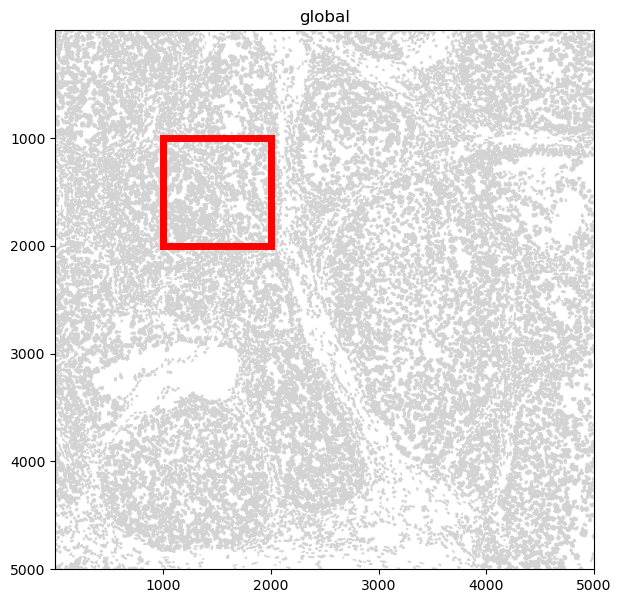

In [13]:
f, ax = plt.subplots(figsize=(7, 7))
sdata.pl.render_shapes(elements="seg_polygons").pl.show(ax=ax)
rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none")
ax.add_patch(rect)

In [14]:
sdata

SpatialData object
├── Images
│     └── 'image': DataTree[cyx] (15, 5000, 5000), (15, 2500, 2500), (15, 1250, 1250)
├── Labels
│     └── 'mask': DataTree[yx] (5000, 5000), (2500, 2500), (1250, 1250)
├── Shapes
│     └── 'seg_polygons': GeoDataFrame shape: (16808, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), seg_polygons (Shapes)

In [19]:
cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
    filter_table=False,
)

In [20]:
cropped_sdata

SpatialData object
├── Images
│     └── 'image': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250)
├── Labels
│     └── 'mask': DataTree[yx] (1000, 1000), (500, 500), (250, 250)
├── Shapes
│     └── 'seg_polygons': GeoDataFrame shape: (819, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), seg_polygons (Shapes)

In [21]:
cropped_sdata.write("../data/sdata/20250225_sdata_subset_cropped.zarr")

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../data/sdata/20250225_sdata_subset_cropped.zarr                                                          


In [22]:
del cropped_sdata
cropped_sdata = spatialdata.read_zarr("../data/sdata/20250225_sdata_subset_cropped.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [23]:
interactive = napari_spatialdata.Interactive(cropped_sdata)
interactive.run()

In [ ]:
# viz in napari is perfect

# large sdata subsetting

In [24]:
sdata = spatialdata.read_zarr("../data/sdata/P26E20_spatialdata/20250225_sdata.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [25]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/P26E20_spatialdata/20250225_sdata.zarr
├── Images
│     └── 'image': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [27]:
sdata['seg_polygons'] = spatialdata.to_polygons(sdata['mask'])

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_19729/1394547182.py:9: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  sdata.pl.render_shapes(elements="seg_polygons").pl.show(ax=ax)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


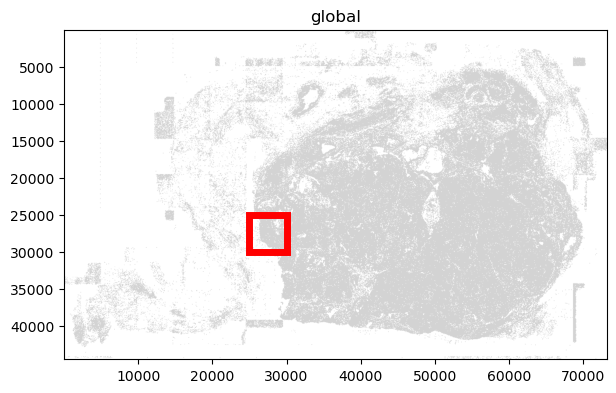

In [28]:
bb_xmin = 25000
bb_ymin = 25000
bb_w = 5000
bb_h = 5000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

f, ax = plt.subplots(figsize=(7, 7))
sdata.pl.render_shapes(elements="seg_polygons").pl.show(ax=ax)
rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none")
ax.add_patch(rect)

In [32]:
sdata.write_element(element_name="seg_polygons")

In [29]:
cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
    filter_table=False,
)

In [ ]:
interactive = napari_spatialdata.Interactive(cropped_sdata)
interactive.run()

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2025-02-25 16:25:47.622 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-02-25 16:25:47.623 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-02-25 16:25:52.872 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-02-25 16:25:52.875 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-02-25 16:25:54.170 | INFO     | napari_spatialdata._viewer:get_sdata_shapes:598 - Multipolygons are present in the data. Only the largest polygon per cell is retained.
2025-02-25 16:26:03.836 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-02-25 16:26:03.841 | DEBUG    | napari_spatialdata._view:_on_layer_up

In [ ]:
# works well, small issue with splitting the image into its various channels.

In [33]:
cropped_sdata.write("../data/sdata/20250225_cropped_5k.zarr")

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside ../data/sdata/20250225_cropped_5k.zarr). Please see the documentation of                
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../data/sdata/20250225_cropped_5k.zarr                                                                    


In [34]:
cropped_sdata.is_backed()

True